# Object-Scene Scaling Analysis

In [174]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem


### Exclusion Criteria
 - Accuracy: 70 % (17/24 correct)
 - RT: Exclude trial if < 250 ms or > 2s
 - Remove participant if more than 10% of the data is removed (?) 
    

### Pilot Analysis Plots

1. Overall Accuracy
    - accuracy by scene category
    - accuracy by zoom 
    - accuracy by zoom x match
2. RT Distribution
    - RT by scene category
    - RT by zoom 
    - RT by zoom x match
3. 2x3 ANOVA
 

In [176]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [177]:
# data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot2'

data_path = '/Users/pmahableshwarkar/Downloads/pilot_b3b4'

In [178]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  43


In [179]:
num_trials = 24

In [180]:
def removeMissedTrials(input_data, num_trials):
    """
    Remove trials where keypress was 'none'
    
    Remove participants who have more than 10% of their data removed
    """
    
    missedTrials_participants = {}
    total_missed = 0
    total = 0
    for idx, row in input_data.iterrows():
        total += 1
        keyPress = row['keyPress']
        if keyPress == 'none':
            total_missed += 1
            subjID = row['subjID']
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            # remove trials with keyPress = none 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(num_trials * 0.1)
    
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))
    print("Percent of missed trials: ", total_missed/total)

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)
    
    return input_data

In [181]:
missed_trial_cleaned_data = removeMissedTrials(input_data, num_trials)

Number of participants with 10% or more missed trials:  15
Percent of missed trials:  0.1065891472868217


In [182]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Remove participants who have more than 10% of their data removed
    
    Returns:
        dataframe with outlier RT trials and outlier participants removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    print("Percent of RT trials outside the outlier range: ", total_RT_outliers/total)
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    return df2, list_trialRT

In [183]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(input_data, [250, 2000], num_trials)


Number of Participants with 10% or more trials outside their RT range:  1
Percent of RT trials outside the outlier range:  0.0045385779122541605


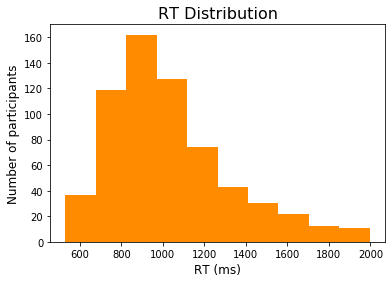

In [184]:
plt.figure()
plt.hist(list(RT_cleaned_data['RT']), color='darkorange')
plt.title('RT Distribution', fontsize=16)
plt.xlabel('RT (ms)', fontsize=12)
plt.ylabel('Number of participants', fontsize=12)
plt.show()

In [185]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
                    
        # minimum number of trials correct the participant must have to be included
        threshold = math.floor(num_trials * accuracy_threshold)
        if subj_num_correct_trials < threshold:
            remove.append(subj)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print('Minimum number of trials correct: ', threshold)
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    return df2, list_trials_correct 

In [186]:
Accuracy_cleaned_data, correct_trials_distribution = Accuracy_Cleaning(RT_cleaned_data, 0.7, num_trials)


Minimum number of trials correct:  16
Number of Participants with accuracy below 70%:  5


In [187]:
np.sum(np.array(Accuracy_cleaned_data['accuracy']))/len(np.array(Accuracy_cleaned_data['accuracy']))

0.8557692307692307

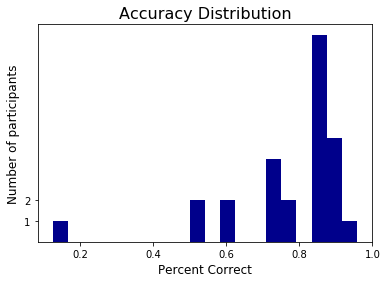

In [188]:
plt.figure()
plt.hist((np.array(correct_trials_distribution))/num_trials, color='darkblue', bins=20)
plt.yticks(np.arange(1,3))
plt.title('Accuracy Distribution', fontsize=16)
plt.xlabel('Percent Correct', fontsize=12)
plt.ylabel('Number of participants', fontsize=12)
plt.show()

In [189]:
final_data = Accuracy_cleaned_data.copy(deep=True)
final_data

,subjID,experimentName,versionName,windowWidth,windowHeight,screenWidth,screenHeight,startDate,startTime,pracTries,...,objectCategory,sceneImage,objectImage,semanticMatch,sceneZoom,keyPress,accuracy,RT,experimentTime,totalTime
0,107406,OSS,v1,877,911,1920,1080,9-5-2022,11-29-11,2,...,classroom,g5_zo.png,c_mouse.png,0,zo,m,1,919,61697,124270
1,107406,OSS,v1,877,911,1920,1080,9-5-2022,11-29-11,2,...,classroom,c2_zc.png,c_eraser.png,1,zc,m,0,1175,61697,124270
2,107406,OSS,v1,877,911,1920,1080,9-5-2022,11-29-11,2,...,gym,g2_zo.png,g_boxingglove.png,1,zo,c,1,1025,61697,124270
3,107406,OSS,v1,877,911,1920,1080,9-5-2022,11-29-11,2,...,bathroom,k2_zi.png,b_toothpaste.png,0,zi,m,1,1190,61697,124270
4,107406,OSS,v1,877,911,1920,1080,9-5-2022,11-29-11,2,...,kitchen,k4_zo.png,k_ovenmitt.png,1,zo,c,1,749,61697,124270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,448423,OSS,v1,1500,749,1200,750,9-5-2022,13-10-50,2,...,bathroom,k5_zo.png,b_soap.png,0,zo,c,0,1006,63778,116513
1027,448423,OSS,v1,1500,749,1200,750,9-5-2022,13-10-50,2,...,bathroom,b0_zo.png,b_toothpaste.png,1,zo,c,1,1081,63778,116513
1028,448423,OSS,v1,1500,749,1200,750,9-5-2022,13-10-50,2,...,gym,c1_zi.png,g_dumbell.png,0,zi,m,1,926,63778,116513
1029,448423,OSS,v1,1500,749,1200,750,9-5-2022,13-10-50,2,...,gym,g3_zi.png,g_jumprope.png,1,zi,c,1,1070,63778,116513


In [190]:
# data split by semantic match
catCongruent_df = final_data.loc[final_data['semanticMatch'] == 1.0]
catIncongruent_df = final_data.loc[final_data['semanticMatch'] == 0.0]


In [191]:
# data split by zoom level 
zo_df = final_data.loc[final_data['sceneZoom'] == 'zo']
zi_df = final_data.loc[final_data['sceneZoom'] == 'zi']
zc_df = final_data.loc[final_data['sceneZoom'] == 'zc']


In [192]:
# semantic matched data across all zooms 
zo_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zo']
zi_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zi']
zc_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zc']


In [193]:
# semantic mis-matched data across all zooms 
zo_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zo']
zi_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zi']
zc_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zc']


## Accuracy


add error bars
- overall accuracy per subj in each condition 

In [194]:
catCongruent_acc = np.sum(np.array(catCongruent_df['accuracy']))/len(np.array(catCongruent_df['accuracy']))
catIncongruent_acc = np.sum(np.array(catIncongruent_df['accuracy']))/len(np.array(catIncongruent_df['accuracy']))

catCongruent_acc, catIncongruent_acc

(0.9111969111969112, 0.8007662835249042)

In [195]:
zo_acc = np.sum(np.array(zo_df['accuracy']))/len(np.array(zo_df['accuracy']))
zi_acc = np.sum(np.array(zi_df['accuracy']))/len(np.array(zi_df['accuracy']))
zc_acc = np.sum(np.array(zc_df['accuracy']))/len(np.array(zc_df['accuracy']))

zo_acc, zi_acc, zc_acc

(0.8470588235294118, 0.8514285714285714, 0.8685714285714285)

In [196]:
zo_catCongruent_acc = np.sum(np.array(zo_catCongruent['accuracy']))/len(np.array(zo_catCongruent['accuracy']))
zi_catCongruent_acc = np.sum(np.array(zi_catCongruent['accuracy']))/len(np.array(zi_catCongruent['accuracy']))
zc_catCongruent_acc = np.sum(np.array(zc_catCongruent['accuracy']))/len(np.array(zc_catCongruent['accuracy']))

zo_catCongruent_acc,  zc_catCongruent_acc, zi_catCongruent_acc

(0.9176470588235294, 0.9195402298850575, 0.896551724137931)

In [197]:
zo_catCongruent_acc_sem = sem(np.array(zo_catCongruent['accuracy']))/len(np.array(zo_catCongruent['accuracy']))
zi_catCongruent_acc_sem = sem(np.array(zi_catCongruent['accuracy']))/len(np.array(zi_catCongruent['accuracy']))
zc_catCongruent_acc_sem = sem(np.array(zc_catCongruent['accuracy']))/len(np.array(zc_catCongruent['accuracy']))



In [198]:
zo_catIncongruent_acc = np.sum(np.array(zo_catIncongruent['accuracy']))/len(np.array(zo_catIncongruent['accuracy']))
zi_catIncongruent_acc = np.sum(np.array(zi_catIncongruent['accuracy']))/len(np.array(zi_catIncongruent['accuracy']))
zc_catIncongruent_acc = np.sum(np.array(zc_catIncongruent['accuracy']))/len(np.array(zc_catIncongruent['accuracy']))

zo_catIncongruent_acc, zc_catIncongruent_acc ,zi_catIncongruent_acc

(0.7764705882352941, 0.8181818181818182, 0.8068181818181818)

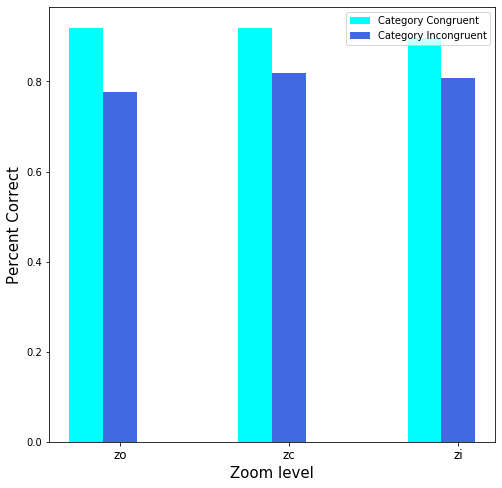

In [199]:
plt.figure(figsize=[8,8])
x = np.arange(3)
#                          z0                   zc                  zi
Acc_catCongruent =   [zo_catCongruent_acc, zc_catCongruent_acc, zi_catCongruent_acc]

Acc_catIncongruent = [zo_catIncongruent_acc, zc_catIncongruent_acc, zi_catIncongruent_acc]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_catCongruent, width, color='cyan', label='Category Congruent')
plt.bar(x, Acc_catIncongruent, width, color='royalblue', label='Category Incongruent')
plt.xticks(x, ['zo', 'zc', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("Percent Correct", fontsize=15)
plt.legend(loc=1, fontsize=10)
plt.show()

### Accuracy by Scene Category

In [200]:
all_sceneCategories = final_data.sceneCategory.unique()
all_sceneCategories = [scene for scene in all_sceneCategories if type(scene) == str]
all_sceneCategories

['gym', 'classroom', 'kitchen', 'bathroom']

In [201]:
scenes = []
scenes_acc = []
for scene in all_sceneCategories:
    scene_df = final_data.loc[final_data['sceneCategory'] == scene]
    scene_acc = np.sum(np.array(scene_df['accuracy']))/len(np.array(scene_df['accuracy']))
    scenes.append(scene)
    scenes_acc.append(scene_acc)


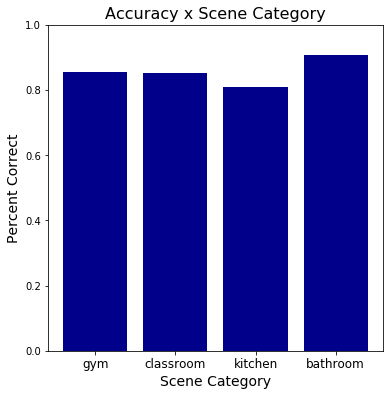

In [202]:
plt.figure(figsize=[6,6])

width = 0.2

plt.xticks(np.arange(len(scenes)), scenes, fontsize=12)
plt.ylim([0, 1])
plt.bar(np.arange(len(scenes)), scenes_acc, color='darkblue')
plt.xlabel('Scene Category', fontsize=14)
plt.ylabel('Percent Correct', fontsize=14)
plt.title('Accuracy x Scene Category', fontsize=16)

plt.show();

## RT

CREATE DIFF DF - ONLY INCLUDE CORRECT TRIALS

WITHIN PARTICIPANT SEM

In [203]:
catCongruent_df_correctOnly = catCongruent_df.loc[catCongruent_df['accuracy'] == 1]
catIncongruent_df_correctOnly = catIncongruent_df.loc[catIncongruent_df['accuracy'] == 1]

catCongruent_RT_correctOnly = np.mean(np.array(catCongruent_df_correctOnly['RT']))
catIncongruent_RT_correctOnly = np.mean(np.array(catIncongruent_df_correctOnly['RT']))

In [204]:
catCongruent_RT = np.mean(np.array(catCongruent_df['RT']))
catIncongruent_RT = np.mean(np.array(catIncongruent_df['RT']))

catCongruent_RT, catIncongruent_RT

(987.0540540540541, 1055.3831417624522)

In [205]:
zo_df_correctOnly = zo_df.loc[zo_df['accuracy'] == 1]
zi_df_correctOnly = zi_df.loc[zi_df['accuracy'] == 1]
zc_df_correctOnly = zc_df.loc[zc_df['accuracy'] == 1]

zo_RT_correctOnly = np.mean(np.array(zo_df_correctOnly['RT']))
zi_RT_correctOnly = np.mean(np.array(zi_df_correctOnly['RT']))
zc_RT_correctOnly = np.mean(np.array(zc_df_correctOnly['RT']))

In [206]:
zo_RT = np.mean(np.array(zo_df['RT']))
zi_RT = np.mean(np.array(zi_df['RT']))
zc_RT = np.mean(np.array(zc_df['RT']))

zo_RT, zi_RT, zc_RT

(991.7235294117647, 1050.04, 1021.44)

In [207]:
zo_catCongruent_correctOnly = zo_catCongruent.loc[zo_catCongruent['accuracy'] == 1]
zi_catCongruent_correctOnly = zi_catCongruent.loc[zi_catCongruent['accuracy'] == 1]
zc_catCongruent_correctOnly = zc_catCongruent.loc[zc_catCongruent['accuracy'] == 1]

zo_catCongruent_RT_correctOnly = np.mean(np.array(zo_catCongruent_correctOnly['RT']))
zi_catCongruent_RT_correctOnly = np.mean(np.array(zi_catCongruent_correctOnly['RT']))
zc_catCongruent_RT_correctOnly = np.mean(np.array(zc_catCongruent_correctOnly['RT']))

In [208]:
zo_catCongruent_RT = np.mean(np.array(zo_catCongruent['RT']))
zi_catCongruent_RT = np.mean(np.array(zi_catCongruent['RT']))
zc_catCongruent_RT = np.mean(np.array(zc_catCongruent['RT']))

zo_catCongruent_RT, zi_catCongruent_RT, zc_catCongruent_RT

(974.2235294117647, 1010.2068965517242, 976.4367816091954)

In [209]:
zo_catCongruent_RT_sem_correctOnly = sem(np.array(zo_catCongruent_correctOnly['RT']))
zi_catCongruent_RT_sem_correctOnly = sem(np.array(zi_catCongruent_correctOnly['RT']))
zc_catCongruent_RT_sem_correctOnly = sem(np.array(zc_catCongruent_correctOnly['RT']))

In [210]:
zo_catCongruent_RT_sem = sem(np.array(zo_catCongruent['RT']))
zi_catCongruent_RT_sem = sem(np.array(zi_catCongruent['RT']))
zc_catCongruent_RT_sem = sem(np.array(zc_catCongruent['RT']))


In [211]:
zo_catIncongruent_correctOnly = zo_catIncongruent.loc[zo_catIncongruent['accuracy']==1]
zi_catIncongruent_correctOnly = zi_catIncongruent.loc[zi_catIncongruent['accuracy']==1]
zc_catIncongruent_correctOnly = zc_catIncongruent.loc[zc_catIncongruent['accuracy']==1]


zo_catIncongruent_RT_correctOnly = np.mean(np.array(zo_catIncongruent_correctOnly['RT']))
zi_catIncongruent_RT_correctOnly = np.mean(np.array(zi_catIncongruent_correctOnly['RT']))
zc_catIncongruent_RT_correctOnly = np.mean(np.array(zc_catIncongruent_correctOnly['RT']))

In [212]:
zo_catIncongruent_RT = np.mean(np.array(zo_catIncongruent['RT']))
zi_catIncongruent_RT = np.mean(np.array(zi_catIncongruent['RT']))
zc_catIncongruent_RT = np.mean(np.array(zc_catIncongruent['RT']))

zo_catIncongruent_RT, zi_catIncongruent_RT, zc_catIncongruent_RT

(1009.2235294117647, 1089.4204545454545, 1065.9318181818182)

In [213]:
zo_catIncongruent_RT_sem_correctOnly = sem(np.array(zo_catIncongruent_correctOnly['RT']))
zi_catIncongruent_RT_sem_correctOnly = sem(np.array(zi_catIncongruent_correctOnly['RT']))
zc_catIncongruent_RT_sem_correctOnly = sem(np.array(zc_catIncongruent_correctOnly['RT']))


In [214]:
zo_catIncongruent_RT_sem = sem(np.array(zo_catIncongruent['RT']))
zi_catIncongruent_RT_sem = sem(np.array(zi_catIncongruent['RT']))
zc_catIncongruent_RT_sem = sem(np.array(zc_catIncongruent['RT']))


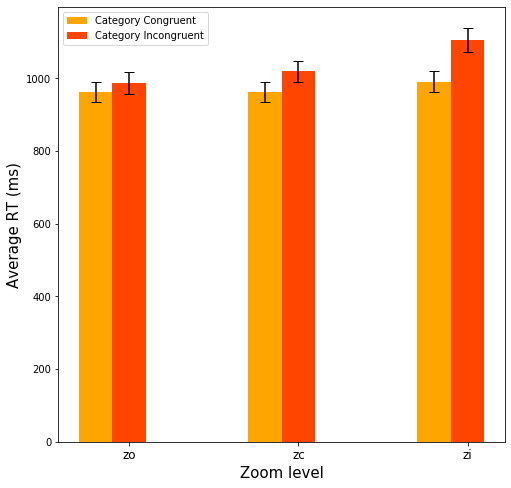

In [215]:
plt.figure(figsize=[8,8])
x = np.arange(3)

#                          z0                   zc                  zi
RT_catCongruent =   [zo_catCongruent_RT_correctOnly, zc_catCongruent_RT_correctOnly, zi_catCongruent_RT_correctOnly]
RT_catCongruent_sem = [zo_catCongruent_RT_sem_correctOnly, zc_catCongruent_RT_sem_correctOnly, zi_catCongruent_RT_sem_correctOnly]
#                          z0                   zc                  zi

RT_catIncongruent = [zo_catIncongruent_RT_correctOnly, zc_catIncongruent_RT_correctOnly, zi_catIncongruent_RT_correctOnly]
RT_catIncongruent_sem = [zo_catIncongruent_RT_sem_correctOnly, zc_catIncongruent_RT_sem_correctOnly, zi_catIncongruent_RT_sem_correctOnly]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_catCongruent, width, color='orange', label='Category Congruent', yerr=RT_catCongruent_sem, capsize=5)
plt.bar(x, RT_catIncongruent, width, color='orangered', label='Category Incongruent', yerr=RT_catIncongruent_sem, capsize=5)
plt.xticks(x, ['zo', 'zc', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("Average RT (ms)", fontsize=15)
plt.legend(loc=2, fontsize=10)
plt.show()

In [216]:
all_sceneCategories = final_data.sceneCategory.unique()
all_sceneCategories = [scene for scene in all_sceneCategories if type(scene) == str]
all_sceneCategories

['gym', 'classroom', 'kitchen', 'bathroom']

In [217]:
scenes = []
scenes_RT = []
scenes_sem = []
for scene in all_sceneCategories:
    scene_df = final_data.loc[final_data['sceneCategory'] == scene]
    scene_RT = np.mean(np.array(scene_df['RT']))
    scene_sem = sem(np.array(scene_df['RT']))
    scenes.append(scene)
    scenes_RT.append(scene_RT)
    scenes_sem.append(scene_sem)


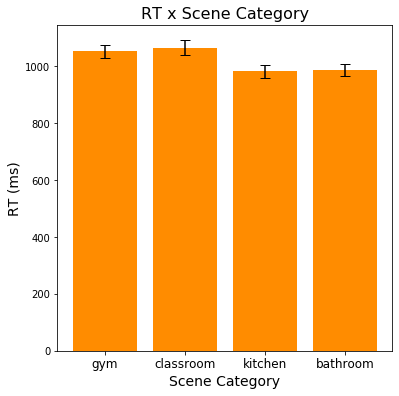

In [218]:
plt.figure(figsize=[6,6])

width = 0.2

plt.xticks(np.arange(len(scenes)), scenes, fontsize=12)
plt.bar(np.arange(len(scenes)), scenes_RT, color='darkorange', yerr = scenes_sem, capsize=5)
plt.xlabel('Scene Category', fontsize=14)
plt.ylabel('RT (ms)', fontsize=14)
plt.title('RT x Scene Category', fontsize=16)

plt.show();

## IES: Inverse Efficiency Score

RT for correct trials only or all?


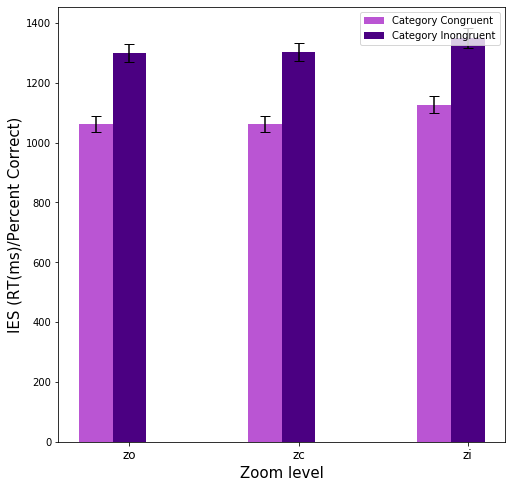

In [219]:
plt.figure(figsize=[8,8])
x = np.arange(3)

#                          z0                   zc                  zi
IES_catCongruent =   [zo_catCongruent_RT/zo_catCongruent_acc, zc_catCongruent_RT/zc_catCongruent_acc, zi_catCongruent_RT/zi_catCongruent_acc]
#                          z0                   zc                  zi

IES_catIncongruent = [zo_catIncongruent_RT/zo_catIncongruent_acc, zc_catIncongruent_RT/zc_catIncongruent_acc, zi_catIncongruent_RT/zi_catIncongruent_acc]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, IES_catCongruent, width, color='mediumorchid', label='Category Congruent', yerr=RT_catCongruent_sem, capsize=5)
plt.bar(x, IES_catIncongruent, width, color='indigo', label='Category Inongruent', yerr=RT_catIncongruent_sem, capsize=5)
plt.xticks(x, ['zo', 'zc', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("IES (RT(ms)/Percent Correct)", fontsize=15)
plt.legend(loc=1, fontsize=10)
plt.show()